# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Код для расчёта энтропии:

In [ ]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения узлов дерева (используйте, например, `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признаков и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

#### Реализация

In [ ]:
iris = datasets.load_iris()

df = pd.DataFrame(data=np.c_[iris['data'], iris['target']], columns=iris['feature_names'] + ['target'])
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [ ]:
def split_func(j, t, df):
    left = df[df[df.columns[j]] < t]
    right = df[df[df.columns[j]] >= t]

    return left, right


def IG_calc(df, sample1, sample2):
    size_R_v = len(df[df.columns[-1]])
    size_R_left = len(sample1[sample1.columns[-1]])
    size_R_right = len(sample2[sample2.columns[-1]])

    IG = entropy(df[df.columns[-1]]) - (
            size_R_left / size_R_v * entropy(sample1[sample1.columns[-1]]) +
            size_R_right / size_R_v * entropy(sample2[sample2.columns[-1]])
    )

    return IG


def get_best_split(df):
    best_j, best_t, best_IG = 0, 0.0, 0.0

    for j in range(len(df.columns) - 1):
        for t in df[df.columns[j]]:
            left, right = split_func(j, t, df)
            cur_IG = IG_calc(df, left, right)

            if cur_IG > best_IG:
                best_j, best_t, best_IG = j, t, cur_IG

    return {'index': best_j, 'value': best_t, 'children': split_func(best_j, best_t, df)}


def to_terminal(sample):
    return sample[sample.columns[-1]].value_counts().index[0]


def split_node(node, max_depth, min_size, purity, depth):
    left, right = node['children']
    del (node['children'])

    if purity:
        if left.value_counts().size == 1:
            to_terminal(left)
            return
        if right.value_counts().size == 1:
            to_terminal(right)
            return

    if left.empty or right.empty:
        node['left'] = node['right'] = to_terminal(pd.concat([left, right]))
        return

    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return

    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_best_split(left)
        split_node(node['left'], max_depth, min_size, purity, depth + 1)

    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_best_split(right)
        split_node(node['right'], max_depth, min_size, purity, depth + 1)


def build_tree(train, max_depth, min_size, purity):
    root = get_best_split(train)
    split_node(root, max_depth, min_size, purity, 1)
    return root


def predict_row(node, df_row):
    if df_row[df_row.columns[node['index']]].iloc[0] < node['value']:
        if isinstance(node['left'], dict):
            return predict_row(node['left'], df_row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict_row(node['right'], df_row)
        else:
            return node['right']


def predict_df(node, df_test):
    y_pred = []
    for i in range(df_test.shape[0]):
        df_row = df_test.iloc[[i]]
        pred_class = predict_row(node, df_row)

        y_pred.append(pred_class)

    return y_pred

#### Тестирование программы

In [ ]:
train_size = 120
df_train = df.sample(train_size, random_state=42)
df_test = df.drop(df_train.index)

max_depth = 3
min_size = 1
tree = build_tree(df_train, max_depth, min_size, False)

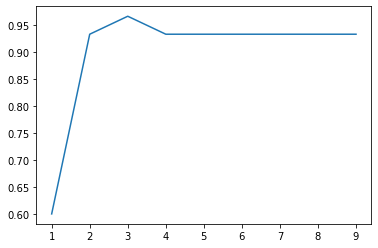

In [ ]:
accuracies = []
for depth in range(1, 10):
    tree = build_tree(df_train, depth, 1, False)

    accuracies.append(accuracy_score(df_test[df_test.columns[-1]], predict_df(tree, df_test)))

plt.plot(range(1, 10), accuracies)

По графику наглядно видно, что наилучшая глубина - 3, где `accuracy` достигает максимального значения из всех, что у нас есть. Дальнейшее же усложнение дерева приведёт к переобучению.

##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.